In [1]:
import pickle
import matplotlib.pyplot as plt

In [2]:
from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras import optimizers
import numpy as np
from keras.layers.core import Lambda
from keras import backend as K
from keras import regularizers

Using TensorFlow backend.


In [3]:
class MNIST_vgg:
    def __init__(self,train=True):
        self.num_classes = 10
        self.weight_decay = 0.0005
        self.x_shape = [32,32,3]

        self.model = self.build_model()
        if train:
            self.model = self.train(self.model)
        else:
            self.model.load_weights('MNIST_vgg.h5')


    def build_model(self):
        # Build the network of vgg for 10 classes with massive dropout and weight decay as described in the paper.

        model = Sequential()
        weight_decay = self.weight_decay

        model.add(Conv2D(64, (3, 3), padding='same',
                         input_shape=self.x_shape,kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.3))

        model.add(Conv2D(64, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(Conv2D(128, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.4))

        model.add(Conv2D(128, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(Conv2D(256, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.4))

        model.add(Conv2D(256, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.4))

        model.add(Conv2D(256, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(MaxPooling2D(pool_size=(2, 2)))


        model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.4))

        model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.4))

        model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(MaxPooling2D(pool_size=(2, 2)))


        model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.4))

        model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.4))

        model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.5))

        model.add(Flatten())
        model.add(Dense(512,kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(Dropout(0.5))
        model.add(Dense(self.num_classes))
        model.add(Activation('softmax'))
        return model


    def normalize(self,X_train,X_test):
        #this function normalize inputs for zero mean and unit variance
        # it is used when training a model.
        # Input: training set and test set
        # Output: normalized training set and test set according to the trianing set statistics.
        mean = np.mean(X_train,axis=(0,1,2,3))
        std = np.std(X_train, axis=(0, 1, 2, 3))
        X_train = (X_train-mean)/(std+1e-7)
        X_test = (X_test-mean)/(std+1e-7)
        return X_train, X_test

    def normalize_production(self,x):
        #this function is used to normalize instances in production according to saved training set statistics
        # Input: X - a training set
        # Output X - a normalized training set according to normalization constants.

        #these values produced during first training and are general for the standard cifar10 training set normalization
        mean = 120.707
        std = 64.15
        return (x-mean)/(std+1e-7)

    def predict(self,x,normalize=True,batch_size=50):
        if normalize:
            x = self.normalize_production(x)
        return self.model.predict(x,batch_size)

    def train(self,model):

        #training parameters
        batch_size = 128
        maxepoches = 25
        learning_rate = 0.1
        lr_decay = 1e-6
        lr_drop = 20
        # The data, shuffled and split between train and test sets:
        x_train,y_train,x_test,y_test = mnist_train_RGB_x,M_train_y,mnist_test_RGB_x,M_test_y
        x_train = x_train.astype('float32')
        x_test = x_test.astype('float32')
        x_train, x_test = self.normalize(x_train, x_test)

        y_train = keras.utils.to_categorical(y_train, self.num_classes)
        y_test = keras.utils.to_categorical(y_test, self.num_classes)

        def lr_scheduler(epoch):
            return learning_rate * (0.5 ** (epoch // lr_drop))
        reduce_lr = keras.callbacks.LearningRateScheduler(lr_scheduler)

        #data augmentation
        datagen = ImageDataGenerator(
            featurewise_center=False,  # set input mean to 0 over the dataset
            samplewise_center=False,  # set each sample mean to 0
            featurewise_std_normalization=False,  # divide inputs by std of the dataset
            samplewise_std_normalization=False,  # divide each input by its std
            zca_whitening=False,  # apply ZCA whitening
            rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
            width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
            height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
            horizontal_flip=True,  # randomly flip images
            vertical_flip=False)  # randomly flip images
        # (std, mean, and principal components if ZCA whitening is applied).
        datagen.fit(x_train)



        #optimization details
        sgd = optimizers.SGD(lr=learning_rate, decay=lr_decay, momentum=0.9, nesterov=True)
        model.compile(loss='categorical_crossentropy', optimizer=sgd,metrics=['accuracy'])


        # training process in a for loop with learning rate drop every 25 epoches.

        historytemp = model.fit_generator(datagen.flow(x_train, y_train,
                                         batch_size=batch_size),
                            steps_per_epoch=x_train.shape[0] // batch_size,
                            epochs=maxepoches,
                            validation_data=(x_test, y_test),callbacks=[reduce_lr],verbose=2)
        model.save_weights('MNIST_vgg.h5')
        return model

In [4]:
class cifar10vgg:
    def __init__(self,train=True):
        self.num_classes = 10
        self.weight_decay = 0.0005
        self.x_shape = [32,32,3]

        self.model = self.build_model()
        if train:
            self.model = self.train(self.model)
        else:
            self.model.load_weights('cifar10vgg.h5')


    def build_model(self):
        # Build the network of vgg for 10 classes with massive dropout and weight decay as described in the paper.

        model = Sequential()
        weight_decay = self.weight_decay

        model.add(Conv2D(64, (3, 3), padding='same',
                         input_shape=self.x_shape,kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.3))

        model.add(Conv2D(64, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(Conv2D(128, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.4))

        model.add(Conv2D(128, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(Conv2D(256, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.4))

        model.add(Conv2D(256, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.4))

        model.add(Conv2D(256, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(MaxPooling2D(pool_size=(2, 2)))


        model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.4))

        model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.4))

        model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(MaxPooling2D(pool_size=(2, 2)))


        model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.4))

        model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.4))

        model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.5))

        model.add(Flatten())
        model.add(Dense(512,kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(Dropout(0.5))
        model.add(Dense(self.num_classes))
        model.add(Activation('softmax'))
        return model


    def normalize(self,X_train,X_test):
        #this function normalize inputs for zero mean and unit variance
        # it is used when training a model.
        # Input: training set and test set
        # Output: normalized training set and test set according to the trianing set statistics.
        mean = np.mean(X_train,axis=(0,1,2,3))
        std = np.std(X_train, axis=(0, 1, 2, 3))
        X_train = (X_train-mean)/(std+1e-7)
        X_test = (X_test-mean)/(std+1e-7)
        return X_train, X_test

    def normalize_production(self,x):
        #this function is used to normalize instances in production according to saved training set statistics
        # Input: X - a training set
        # Output X - a normalized training set according to normalization constants.

        #these values produced during first training and are general for the standard cifar10 training set normalization
        mean = 120.707
        std = 64.15
        return (x-mean)/(std+1e-7)

    def predict(self,x,normalize=True,batch_size=50):
        if normalize:
            x = self.normalize_production(x)
        return self.model.predict(x,batch_size)

    def train(self,model):

        #training parameters
        batch_size = 128
        maxepoches = 250
        learning_rate = 0.1
        lr_decay = 1e-6
        lr_drop = 20
        # The data, shuffled and split between train and test sets:
        (x_train, y_train), (x_test, y_test) = cifar10.load_data()
        x_train = x_train.astype('float32')
        x_test = x_test.astype('float32')
        x_train, x_test = self.normalize(x_train, x_test)

        y_train = keras.utils.to_categorical(y_train, self.num_classes)
        y_test = keras.utils.to_categorical(y_test, self.num_classes)

        def lr_scheduler(epoch):
            return learning_rate * (0.5 ** (epoch // lr_drop))
        reduce_lr = keras.callbacks.LearningRateScheduler(lr_scheduler)

        #data augmentation
        datagen = ImageDataGenerator(
            featurewise_center=False,  # set input mean to 0 over the dataset
            samplewise_center=False,  # set each sample mean to 0
            featurewise_std_normalization=False,  # divide inputs by std of the dataset
            samplewise_std_normalization=False,  # divide each input by its std
            zca_whitening=False,  # apply ZCA whitening
            rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
            width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
            height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
            horizontal_flip=True,  # randomly flip images
            vertical_flip=False)  # randomly flip images
        # (std, mean, and principal components if ZCA whitening is applied).
        datagen.fit(x_train)



        #optimization details
        sgd = optimizers.SGD(lr=learning_rate, decay=lr_decay, momentum=0.9, nesterov=True)
        model.compile(loss='categorical_crossentropy', optimizer=sgd,metrics=['accuracy'])


        # training process in a for loop with learning rate drop every 25 epoches.

        historytemp = model.fit_generator(datagen.flow(x_train, y_train,
                                         batch_size=batch_size),
                            steps_per_epoch=x_train.shape[0] // batch_size,
                            epochs=maxepoches,
                            validation_data=(x_test, y_test),callbacks=[reduce_lr],verbose=2)
        model.save_weights('cifar10vgg.h5')
        return model

In [5]:
fp = open("MNIST-VGG-1.pkl","rb+")
M_VGG_Model1 = pickle.load(fp, encoding='bytes')
fp = open("MNIST-VGG-2.pkl","rb+")
M_VGG_Model2 = pickle.load(fp, encoding='bytes')
fp = open("MNIST-VGG-3.pkl","rb+")
M_VGG_Model3 = pickle.load(fp, encoding='bytes')
fp = open("CIFAR-VGG-1.pkl","rb+")
C_VGG_Model1 = pickle.load(fp, encoding='bytes')
fp = open("CIFAR-VGG-2.pkl","rb+")
C_VGG_Model2 = pickle.load(fp, encoding='bytes')
fp = open("CIFAR-VGG-3.pkl","rb+")
C_VGG_Model3 = pickle.load(fp, encoding='bytes')

W1025 15:12:25.501047 19256 deprecation_wrapper.py:119] From c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1025 15:12:25.513652 19256 deprecation_wrapper.py:119] From c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1025 15:12:25.532966 19256 deprecation_wrapper.py:119] From c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\backend\tensorflow_backend.py:245: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1025 15:12:25.533960 19256 deprecation_wrapper.py:119] From c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\backend\tensorflow_backend.py:174: The name tf.get_default_session is depre

In [6]:
mnist = keras.datasets.mnist
(mnist_train_x, mnist_train_y), (mnist_test_x, mnist_test_y)\
    = mnist.load_data()
def MNIST_To_CIFAR_FORM(mnist_train_x, mnist_train_y,mnist_test_x, mnist_test_y):
    """
    Change the one-channel to RBG-channel on mnist_train_x and mnist_test_x
    Change the shape of mnist_train_y and mnist_test_y from (length) to (length,1)
    ---------------------------------------
    inputs:
    mnist_train_x, mnist_train_y,mnist_test_x, mnist_test_y which is all multi-dimension array
    It is recommended to use the following way to import the data
    ========================== codes ==========================
    mnist = keras.datasets.mnist
    (mnist_train_x, mnist_train_y), (mnist_test_x, mnist_test_y)\
    = mnist.load_data()
    ========================== codes ==========================
    outputs:
    mnist_train_RGB_x, M_train_y, mnist_test_RGB_x, M_test_y 
    """
    from skimage import exposure
    import imutils
    B= []
    for i in range(len(mnist_train_x)):
        A = mnist_train_x[i]
        A = exposure.rescale_intensity(A, out_range=(0, 255))
        A = imutils.resize(A, width=32)
        B.append(A)
    B = np.array(B)

    mnist_train_RGB_x = np.repeat(B[:,:, :, np.newaxis], 3, axis=3)
    B= []
    for i in range(len(mnist_test_x)):
        A = mnist_test_x[i]
        A = exposure.rescale_intensity(A, out_range=(0, 255))
        A = imutils.resize(A, width=32)
        B.append(A)
    B = np.array(B)

    mnist_test_RGB_x = np.repeat(B[:,:, :, np.newaxis], 3, axis=3)
    M_train_y = np.array([[mnist_train_y[i]] for i in range(len(mnist_train_y))])
    M_test_y = np.array([[mnist_test_y[i]] for i in range(len(mnist_test_y))])
    return mnist_train_RGB_x, M_train_y, mnist_test_RGB_x, M_test_y

In [7]:
mnist_train_RGB_x, M_train_y, mnist_test_RGB_x, M_test_y = MNIST_To_CIFAR_FORM(mnist_train_x, mnist_train_y,mnist_test_x, mnist_test_y)
(C_x_train, C_y_train), (C_x_test, C_y_test) = cifar10.load_data()

In [8]:
from sklearn.metrics.pairwise import cosine_similarity
def get_the_orignal_index_after_ranking(arr, isReverse = True):
    """
    This function return the orignal index of the after the array is sorted
    inputs:
    arr || one dimension list or ndarray
    isReverse || boolean, if it is "True" the rank is decending; if it is "False" the rank is ascending 
    outputs:
    A || an arr including the orignal index before ranking
    ========================= examples =========================
    For example, arr = [4,7,2,9]
    we have the mapping relationship:
    index    value
      0        4
      1        7
      2        2
      3        9
    After sorting, say decendingly, we have:
    orignal_index     value
      3                 9
      1                 7
      0                 4
      2                 2    
    the result is for this function is [3,1,0,2].
    """
    import operator
    similarity_dict = dict(zip(list(range(len(arr))),arr))
    sorted_similarity_dict = sorted(similarity_dict.items(), reverse=isReverse, key=operator.itemgetter(1))
    A = [sorted_similarity_dict[i][0] for i in range(len(arr))]
    return A

In [9]:
def find_idx(arr, target):
    ans = []
    for i in range(len(arr)):
        if arr[i] == target:
            ans.append(i)
    return ans
def get_submax(arr):
    arr = np.array(arr)
    MAX = np.max(arr)
    idx = find_idx(arr, MAX)
    arr_without_max = np.delete(arr,idx)
    return np.max(arr_without_max)
def find_statistics(Prob_Mat):
    Prob_diff = []
    MAX_Prob_Mat = []
    MAX_Prob_Mat_idx = []
    subMAX_Prob_Mat = []
    subMAX_Prob_Mat_idx = []
    for i in range(len(Prob_Mat)):
        MAX = np.max(Prob_Mat[i])
        MAX_idx = find_idx(Prob_Mat[i], MAX)[0]
        subMAX = get_submax(Prob_Mat[i])
        subMAX_idx = find_idx(Prob_Mat[i], subMAX)[0]
        prob_difference = MAX - subMAX
        Prob_diff.append(prob_difference)
        MAX_Prob_Mat.append(MAX)
        subMAX_Prob_Mat.append(subMAX)
        MAX_Prob_Mat_idx.append(MAX_idx)
        subMAX_Prob_Mat_idx.append(subMAX_idx)
    return Prob_diff,MAX_Prob_Mat,MAX_Prob_Mat_idx,subMAX_Prob_Mat,subMAX_Prob_Mat_idx
def separate_one_class(target_class_label, x_train, y_train, x_test, y_test):
    with_train_idx = find_idx(y_train, target_class_label)
    with_test_idx = find_idx(y_test, target_class_label)
    without_train_idx = list(set(range(len(y_train))).difference(set(with_train_idx)))
    without_test_idx = list(set(range(len(y_test))).difference(set(with_test_idx)))
    with_train = x_train[with_train_idx]
    with_test = x_test[with_test_idx]
    without_train = x_train[without_train_idx]
    without_test = x_test[without_test_idx]
    with_train_y = y_train[with_train_idx]
    with_test_y = y_test[with_test_idx]
    without_train_y = y_train[without_train_idx]
    without_test_y = y_test[without_test_idx]
    return with_train, with_train_y, without_train, without_train_y, with_test, with_test_y, without_test, without_test_y
def minkowski_distance(x,y,n):
    if np.isinf(n):
        if n>0:
            return np.max(np.abs(x-y))
        else:
            return np.min(np.abs(x-y))
    else:
        return np.power(np.sum(np.power(np.abs(x-y),n)),1/n)
def minkowski_similarity(x,Y,n):
    arr = []
    for y in Y:
        arr.append(minkowski_distance(x,y,n))
    return np.array(arr)

def get_KNN_stats(k,testarr_one_sample, testarr_waiting_to_compare, 
                  testarr_waiting_to_compare_label, Model, similarity_method = 'cosine_similarity', minkowski_power = 2):
    """
    Inputs Example:
    k = 50
    testarr_one_sample = [mnist_train_RGB_x[0]]
    testarr_waiting_to_compare = [C_x_train[i] for i in range(5000)]
    testarr_waiting_to_compare_label = C_y_train[:5000].reshape(5000)
    Model = C_VGG_Model1.model
    
    Inputs:
    k: int, the number of the nearest neighbour
    testarr_one_sample: multi-dimensional ndarray, shape = (1,num_pixel_x,num_pixel_y,num_channel)
    testarr_waiting_to_compare_label: multi-dimensional ndarray, shape = (num_neighbour_candidate,num_pixel_x,num_pixel_y,num_channel)
    testarr_waiting_to_compare_label: one-dimensional ndarray, shape = (num_neighbour_candidate,)
    Model: keras backend model
    similarity_method: String, 'cosine_similarity', 'minkowski_similarity'. Default = 'cosine_similarity'
    minkowski_power: int, the p-value in the minkowski_distance. Only useful when similarity_method = 'minkowski_similarity'
    
    Outputs:
    similarity: one-dimensional ndarray, shape = (num_neighbour_candidate,)
    K_nearest_neighbour_orignal_label: one-dimensional ndarray, shape = (k,)
    K_nearest_neighbour: multi-dimensional ndarray, shape = (k,num_pixel_x,num_pixel_y,num_channel)
    KNN_oringal_class: dictionary, counts of the orignal class
    max_ratio_KNN_from_one_class: float, the max of the ratio of KNN are from one class
    """
    from keras import backend as K
    testarr_waiting_to_compare = np.array(testarr_waiting_to_compare)
    inp = Model.model.input                                           # input placeholder
    outputs = Model.model.layers[58].output          # all layer outputs
    functors = K.function([inp, K.learning_phase()], [outputs])   # evaluation functions

    # Testing
    test1 = testarr_one_sample
    layer_outs_one_sample = functors([test1, 0.])
    layer_outs_one_sample = np.array(layer_outs_one_sample)[0]

    test2 = testarr_waiting_to_compare
    layer_outs_waiting_to_compare = functors([test2, 0.])
    layer_outs_waiting_to_compare = np.array(layer_outs_waiting_to_compare)[0]
    if similarity_method == 'cosine_similarity':
        from sklearn.metrics.pairwise import cosine_similarity
        similarity = cosine_similarity(layer_outs_one_sample, layer_outs_waiting_to_compare)
        similarity = np.array(similarity[0])
        K_nearest_neighbour_orignal_label = get_the_orignal_index_after_ranking(similarity)[:k]
    elif similarity_method == 'minkowski_similarity':
        similarity = minkowski_similarity(layer_outs_one_sample, layer_outs_waiting_to_compare, minkowski_power)
        K_nearest_neighbour_orignal_label = get_the_orignal_index_after_ranking(similarity, isReverse = False)[:k]
    else:
        raise Exception("invalid similarity method")
    K_nearest_neighbour_orignal_label = np.array(K_nearest_neighbour_orignal_label)
    K_nearest_neighbour = testarr_waiting_to_compare[K_nearest_neighbour_orignal_label]
    from collections import Counter
    KNN_oringal_class = Counter(testarr_waiting_to_compare_label[K_nearest_neighbour_orignal_label])
    max_ratio_KNN_from_one_class = max(KNN_oringal_class.values())/k
    import operator
    max_KNN_class_label = max(KNN_oringal_class.items(), key=operator.itemgetter(1))[0]
    return similarity, K_nearest_neighbour_orignal_label, K_nearest_neighbour, KNN_oringal_class, max_ratio_KNN_from_one_class, max_KNN_class_label

In [10]:
def show(columns,rows,arr):
    w=10
    h=10
    fig=plt.figure(figsize=(8, 8))
    for i in range(1, columns*rows +1):
        img = arr[i-1]
        fig.add_subplot(rows, columns, i)
        plt.imshow(img)
    plt.show()
    return

In [11]:
# VGG_Model trained by MNIST (using MNIST Representation)
k = 50
testarr_one_sample = [C_x_train[0]]
testarr_waiting_to_compare = [mnist_train_RGB_x[i] for i in range(5000)]
testarr_waiting_to_compare_label = M_train_y[:5000].reshape(5000)
Model = M_VGG_Model1.model

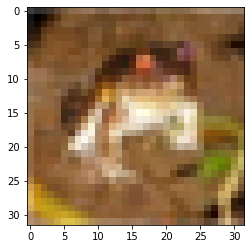

In [30]:
# The testarr_one_sample
plt.imshow(testarr_one_sample[0])

In [31]:
result_cosine_similarity = get_KNN_stats(k,testarr_one_sample, testarr_waiting_to_compare, 
                  testarr_waiting_to_compare_label, Model, similarity_method = 'cosine_similarity', minkowski_power = 2)

c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


In [32]:
# The similarity between the testarr_one_sample and testarr_waiting_to_compare
sorted(result_cosine_similarity[0],reverse = True)

[0.9946154,
 0.99435085,
 0.9942082,
 0.9924308,
 0.9923961,
 0.99234796,
 0.9922237,
 0.9920227,
 0.9920045,
 0.99198645,
 0.99176615,
 0.9900814,
 0.9900671,
 0.9897597,
 0.9897376,
 0.98947555,
 0.9894265,
 0.98934466,
 0.989183,
 0.98887444,
 0.98885095,
 0.9884677,
 0.9880984,
 0.9879645,
 0.9875946,
 0.98753965,
 0.98718184,
 0.9871159,
 0.9870521,
 0.98696434,
 0.986882,
 0.9863211,
 0.9862832,
 0.98621446,
 0.98610306,
 0.98568004,
 0.98532975,
 0.985144,
 0.9851257,
 0.9851171,
 0.98501223,
 0.9847546,
 0.98465663,
 0.9846278,
 0.9846233,
 0.98442554,
 0.98438406,
 0.9840323,
 0.9840015,
 0.98398226,
 0.98395103,
 0.9839275,
 0.983823,
 0.98381466,
 0.9837733,
 0.98360425,
 0.98309445,
 0.9830908,
 0.982921,
 0.9827343,
 0.9826038,
 0.9824745,
 0.9823616,
 0.9823056,
 0.98226184,
 0.9821801,
 0.98217124,
 0.98191404,
 0.98186773,
 0.9818534,
 0.9818406,
 0.9818047,
 0.981768,
 0.98176,
 0.9816847,
 0.9816651,
 0.98163307,
 0.98156303,
 0.9814839,
 0.9813829,
 0.98135936,
 0.98

In [36]:
# The percentage of the K-nearest neighbours are from the same class
result_cosine_similarity[4]

0.96

In [12]:
arr_KNN_from_same_class_ratio = []
arr_KNN_max_class_label = []
for j in range(500):
    print("current sample: ", j)
    k = 50
    testarr_one_sample = [C_x_train[j]]
    testarr_waiting_to_compare = [mnist_train_RGB_x[i] for i in range(5000)]
    testarr_waiting_to_compare_label = M_train_y[:5000].reshape(5000)
    Model = M_VGG_Model1.model
    result_cosine_similarity = get_KNN_stats(k,testarr_one_sample, testarr_waiting_to_compare, 
                  testarr_waiting_to_compare_label, Model, similarity_method = 'minkowski_similarity', minkowski_power = 2)
    arr_KNN_from_same_class_ratio.append(result_cosine_similarity[4])
    arr_KNN_max_class_label.append(result_cosine_similarity[5])
print(np.mean(arr_KNN_from_same_class_ratio))

current sample:  0


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  1
current sample:  2
current sample:  3
current sample:  4
current sample:  5
current sample:  6
current sample:  7
current sample:  8
current sample:  9
current sample:  10
current sample:  11
current sample:  12
current sample:  13
current sample:  14
current sample:  15
current sample:  16
current sample:  17
current sample:  18
current sample:  19
current sample:  20
current sample:  21
current sample:  22
current sample:  23
current sample:  24
current sample:  25
current sample:  26
current sample:  27
current sample:  28
current sample:  29
current sample:  30
current sample:  31
current sample:  32
current sample:  33
current sample:  34
current sample:  35
current sample:  36
current sample:  37
current sample:  38
current sample:  39
current sample:  40
current sample:  41
current sample:  42
current sample:  43
current sample:  44
current sample:  45
current sample:  46
current sample:  47
current sample:  48
current sample:  49
current sample:  50
current s

current sample:  397
current sample:  398
current sample:  399
current sample:  400
current sample:  401
current sample:  402
current sample:  403
current sample:  404
current sample:  405
current sample:  406
current sample:  407
current sample:  408
current sample:  409
current sample:  410
current sample:  411
current sample:  412
current sample:  413
current sample:  414
current sample:  415
current sample:  416
current sample:  417
current sample:  418
current sample:  419
current sample:  420
current sample:  421
current sample:  422
current sample:  423
current sample:  424
current sample:  425
current sample:  426
current sample:  427
current sample:  428
current sample:  429
current sample:  430
current sample:  431
current sample:  432
current sample:  433
current sample:  434
current sample:  435
current sample:  436
current sample:  437
current sample:  438
current sample:  439
current sample:  440
current sample:  441
current sample:  442
current sample:  443
current sampl

In [13]:
import pandas as pd
df = pd.DataFrame({'arr_KNN_max_class_label':arr_KNN_max_class_label,
                   'arr_KNN_from_same_class_ratio':arr_KNN_from_same_class_ratio,
                   'predicted_label':find_statistics(pred_labels)[2],
                  'predicted_prob':find_statistics(pred_labels)[1],})

NameError: name 'pred_labels' is not defined

In [ ]:
df

In [59]:
M_VGG_Model1.model.layers

In [60]:
M_VGG_Model1.model.layers[58]
#<keras.layers.core.Activation at 0x252eb7f72b0>

### Try different CIFAR sample (but from same cifar class) to see if most of the MNIST nearest neighbour is from the same mnist class

In [63]:
separate_6_result = separate_one_class(6, C_x_train, C_y_train, C_x_test, C_y_test)
CIFAR_6_train = separate_6_result[0]

In [66]:
arr_KNN_from_same_class_ratio_6 = []
arr_KNN_max_class_label_6 = []
for j in range(500):
    print("current sample: ", j)
    k = 50
    testarr_one_sample = [CIFAR_6_train[j]]
    testarr_waiting_to_compare = [mnist_train_RGB_x[i] for i in range(5000)]
    testarr_waiting_to_compare_label = M_train_y[:5000].reshape(5000)
    Model = M_VGG_Model1.model
    result_cosine_similarity = get_KNN_stats(k,testarr_one_sample, testarr_waiting_to_compare, 
                  testarr_waiting_to_compare_label, Model, similarity_method = 'cosine_similarity', minkowski_power = 2)
    arr_KNN_from_same_class_ratio_6.append(result_cosine_similarity[4])
    arr_KNN_max_class_label_6.append(result_cosine_similarity[5])
print(np.mean(arr_KNN_from_same_class_ratio_6))

current sample:  0


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  1


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  2


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  3


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  4


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  5


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  6


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  7


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  8


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  9


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  10


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  11


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  12


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  13


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  14


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  15


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  16


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  17


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  18


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  19


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  20


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  21


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  22


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  23


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  24


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  25


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  26


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  27


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  28


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  29


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  30


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  31


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  32


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  33


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  34


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  35


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  36


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  37


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  38


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  39


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  40


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  41


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  42


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  43


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  44


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  45


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  46


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  47


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  48


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  49


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  50


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  51


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  52


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  53


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  54


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  55


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  56


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  57


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  58


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  59


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  60


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  61


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  62


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  63


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  64


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  65


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  66


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  67


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  68


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  69


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  70


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  71


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  72


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  73


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  74


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  75


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  76


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  77


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  78


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  79


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  80


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  81


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  82


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  83


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  84


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  85


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  86


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  87


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  88


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  89


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  90


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  91


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  92


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  93


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  94


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  95


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  96


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  97


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  98


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  99


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  100


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  101


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  102


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  103


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  104


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  105


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  106


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  107


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  108


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  109


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  110


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  111


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  112


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  113


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  114


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  115


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  116


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  117


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  118


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  119


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  120


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  121


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  122


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  123


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  124


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  125


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  126


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  127


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  128


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  129


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  130


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  131


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  132


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  133


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  134


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  135


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  136


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  137


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  138


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  139


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  140


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  141


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  142


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  143


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  144


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  145


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  146


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  147


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  148


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  149


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  150


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  151


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  152


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  153


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  154


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  155


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  156


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  157


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  158


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  159


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  160


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  161


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  162


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  163


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  164


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  165


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  166


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  167


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  168


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  169


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  170


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  171


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  172


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  173


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  174


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  175


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  176


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  177


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  178


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  179


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  180


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  181


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  182


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  183


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  184


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  185


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  186


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  187


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  188


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  189


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  190


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  191


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  192


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  193


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  194


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  195


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  196


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  197


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  198


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  199


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  200


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  201


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  202


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  203


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  204


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  205


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  206


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  207


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  208


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  209


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  210


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  211


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  212


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  213


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  214


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  215


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  216


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  217


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  218


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  219


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  220


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  221


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  222


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  223


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  224


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  225


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  226


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  227


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '
c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  228
current sample:  229


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  230


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  231


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  232


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  233


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  234


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  235


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  236


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  237


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  238


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  239


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  240


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  241


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  242


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  243


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  244


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  245


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  246


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  247


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  248


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  249


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  250


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  251


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  252


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  253


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  254


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  255


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  256


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  257


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  258


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  259


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  260


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  261


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  262


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  263


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  264


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  265


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  266


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  267


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  268


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  269


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  270


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  271


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  272


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  273


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  274


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  275


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  276


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  277


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  278


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  279


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  280


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  281


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  282


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  283


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  284


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  285


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  286


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  287


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  288


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  289


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  290


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  291


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  292


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  293


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  294


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  295


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  296


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  297


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  298


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  299


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  300


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  301


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  302


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  303


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  304


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  305


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  306


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  307


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  308


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  309


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  310


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  311


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  312


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  313


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  314


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  315


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  316


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  317


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  318


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  319


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  320


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  321


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  322


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  323


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  324


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  325


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  326


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  327


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  328


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  329


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  330


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  331


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  332


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  333


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  334


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  335


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  336


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  337


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  338


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  339


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  340


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  341


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  342


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  343


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  344


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  345


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  346


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  347


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  348


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  349


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  350


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  351


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  352


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  353


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  354


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  355


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  356


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  357


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  358


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  359


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  360


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  361


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  362


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  363


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  364


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  365


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  366


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  367


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  368


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  369


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  370


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  371


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  372


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  373


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  374


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  375


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  376


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  377


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  378


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  379


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  380


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  381


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  382


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  383


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  384


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  385


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  386


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  387


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  388


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  389


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  390


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  391


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  392


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  393


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  394


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  395


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  396


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  397


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  398


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  399


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  400


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  401


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  402


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  403


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  404


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  405


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  406


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  407


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  408


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  409


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  410


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  411


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  412


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  413


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  414


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  415


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  416


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  417


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  418


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  419


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  420


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  421


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  422


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  423


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  424


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  425


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  426


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  427


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  428


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  429


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  430


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  431


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  432


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  433


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  434


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  435


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  436


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  437


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  438


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  439


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  440


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  441


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  442


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  443


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  444


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  445


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  446


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  447


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  448


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  449


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  450


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  451


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  452


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  453


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  454


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  455


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  456


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  457


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  458


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  459


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  460


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  461


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  462


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  463


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  464


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  465


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  466


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  467


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  468


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  469


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  470


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  471


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  472


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  473


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  474


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  475


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  476


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  477


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  478


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  479


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  480


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  481


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  482


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  483


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  484


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  485


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  486


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  487


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  488


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  489


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  490


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  491


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  492


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  493


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  494


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  495


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  496


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  497


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  498


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  499


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


0.8356399999999999


NameError: name 'arr_KNN_max_class_label_6' is not defined

In [18]:
# VGG_Model trained by CIFAR (using CIFAR Representation)
k = 50
testarr_one_sample = [mnist_train_RGB_x[0]]
testarr_waiting_to_compare = [C_x_train[i] for i in range(5000)]
testarr_waiting_to_compare_label = C_y_train[:5000].reshape(5000)
Model = C_VGG_Model1.model

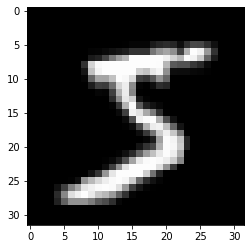

In [19]:
# The testarr_one_sample
plt.imshow(testarr_one_sample[0])

In [20]:
result_cosine_similarity = get_KNN_stats(k,testarr_one_sample, testarr_waiting_to_compare, 
                  testarr_waiting_to_compare_label, Model, similarity_method = 'cosine_similarity', minkowski_power = 2)

c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


In [21]:
# The similarity between the testarr_one_sample and testarr_waiting_to_compare
sorted(result_cosine_similarity[0],reverse = True)

[0.96241117,
 0.96013933,
 0.95920205,
 0.9576292,
 0.9569813,
 0.95554173,
 0.955304,
 0.95487857,
 0.9543199,
 0.953292,
 0.9523239,
 0.95216966,
 0.95152396,
 0.9501773,
 0.95015126,
 0.94950783,
 0.9491819,
 0.9490198,
 0.9473899,
 0.9472636,
 0.94672984,
 0.94650054,
 0.9459254,
 0.94572496,
 0.94532657,
 0.9449668,
 0.9445191,
 0.94430095,
 0.94417274,
 0.9436266,
 0.943488,
 0.943311,
 0.9429629,
 0.94223535,
 0.9421559,
 0.9421007,
 0.9420961,
 0.9418357,
 0.94157577,
 0.9413471,
 0.9413142,
 0.94113356,
 0.9409011,
 0.94025266,
 0.94012976,
 0.9396031,
 0.9390741,
 0.93859065,
 0.9384337,
 0.9383008,
 0.9379587,
 0.9374593,
 0.9374014,
 0.93724924,
 0.93711436,
 0.9366023,
 0.93609023,
 0.93606395,
 0.93546665,
 0.935389,
 0.9350709,
 0.93489355,
 0.93481314,
 0.9347941,
 0.9347571,
 0.9346645,
 0.934649,
 0.934485,
 0.9340373,
 0.9339997,
 0.9338527,
 0.9338407,
 0.9337597,
 0.9333888,
 0.9330646,
 0.9329484,
 0.9324813,
 0.9320583,
 0.93194634,
 0.9319439,
 0.93186104,
 0.93

In [22]:
# The percentage of the K-nearest neighbours are from the same class
result_cosine_similarity[4]

0.24

In [ ]:
def KNN_softmax_consistency():
    arr_KNN_from_same_class_ratio = []
    arr_KNN_max_class_label = []
    for j in range(500):
        print("current sample: ", j)
        k = 50
        testarr_one_sample = [mnist_train_RGB_x[j]]
        testarr_waiting_to_compare = [C_x_train[i] for i in range(5000)]
        testarr_waiting_to_compare_label = C_y_train[:5000].reshape(5000)
        Model = C_VGG_Model1.model
        result_cosine_similarity = get_KNN_stats(k,testarr_one_sample, testarr_waiting_to_compare, 
                      testarr_waiting_to_compare_label, Model, similarity_method = 'cosine_similarity', minkowski_power = 2)
        arr_KNN_from_same_class_ratio.append(result_cosine_similarity[4])
        arr_KNN_max_class_label.append(result_cosine_similarity[5])

In [13]:
arr_KNN_from_same_class_ratio = []
arr_KNN_max_class_label = []
for j in range(500):
    print("current sample: ", j)
    k = 50
    testarr_one_sample = [mnist_train_RGB_x[j]]
    testarr_waiting_to_compare = [C_x_train[i] for i in range(5000)]
    testarr_waiting_to_compare_label = C_y_train[:5000].reshape(5000)
    Model = C_VGG_Model1.model
    result_cosine_similarity = get_KNN_stats(k,testarr_one_sample, testarr_waiting_to_compare, 
                  testarr_waiting_to_compare_label, Model, similarity_method = 'cosine_similarity', minkowski_power = 2)
    arr_KNN_from_same_class_ratio.append(result_cosine_similarity[4])
    arr_KNN_max_class_label.append(result_cosine_similarity[5])
print(np.mean(arr_KNN_from_same_class_ratio))

current sample:  0
current sample:  1


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  2


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  3


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  4


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  5


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  6


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  7


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  8


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  9


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  10


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  11


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  12


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  13


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  14


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  15


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  16


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  17


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  18


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  19


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  20


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  21


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  22


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  23


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  24


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  25


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  26


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  27


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  28


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  29


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  30


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  31


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  32


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  33


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  34


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  35


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  36


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  37


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  38


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  39


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  40


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  41


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  42


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  43


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  44


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  45


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  46


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  47


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  48


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  49


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  50


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  51


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  52


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  53


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  54


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  55


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  56


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  57


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  58


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  59


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  60


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  61


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  62


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  63


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  64


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  65


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  66


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  67


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  68


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  69


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  70


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  71


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  72


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  73


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  74


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  75


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  76


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  77


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  78


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  79


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  80


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  81


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  82


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  83


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  84


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  85


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  86


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  87


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  88


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  89


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  90


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  91


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  92


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  93


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  94


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  95


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  96


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  97


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  98


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  99


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  100


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  101


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  102


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  103


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  104


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  105


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  106


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  107


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  108


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  109


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  110


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  111


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  112


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  113


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  114


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  115


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  116


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  117


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  118


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  119


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  120


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  121


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  122


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  123


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  124


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  125


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  126


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  127


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  128


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  129


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  130


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  131


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  132


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  133


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  134


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  135


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  136


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  137


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  138


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  139


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  140


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  141


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  142


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  143


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  144


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  145


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  146


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  147


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  148


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  149


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  150


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  151


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  152


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  153


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  154


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  155


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  156


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  157


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  158


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  159


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  160


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  161


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  162


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  163


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  164


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  165


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  166


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  167


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  168


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  169


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  170


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  171


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  172


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  173


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  174


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  175


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  176


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  177


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  178


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  179


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  180


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  181


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  182


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  183


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  184


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  185


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  186


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  187


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  188


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  189


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  190


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  191


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  192


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  193


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  194


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  195


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  196


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  197


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  198


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  199


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  200


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  201


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  202


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  203


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  204


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  205


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  206


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  207


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  208


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  209


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  210


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  211


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  212


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  213


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  214


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  215


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  216


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  217


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  218


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  219


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  220


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  221


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  222


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  223


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  224


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  225


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  226


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  227


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  228


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  229


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  230


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  231


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  232


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  233


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  234


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  235


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  236


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  237


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  238


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  239


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  240


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  241


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  242


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  243


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  244


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  245


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  246


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  247


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  248


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  249


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  250


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  251


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  252


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  253


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  254


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  255


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  256


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  257


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  258


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  259


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  260


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  261


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  262


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  263


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  264


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  265


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  266


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  267


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  268


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  269


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  270


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  271


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  272


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  273


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  274


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  275


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  276


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  277


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  278


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  279


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  280


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  281


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  282


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  283


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  284


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  285


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  286


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  287


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  288


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  289


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  290


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  291


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  292


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  293


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  294


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  295


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  296


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  297


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  298


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  299


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  300


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  301


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  302


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  303


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  304


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  305


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  306


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  307


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  308


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  309


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  310


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  311


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  312


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  313


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  314


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  315


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  316


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  317


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  318


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  319


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  320


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  321


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  322


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  323


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  324


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  325


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  326


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  327


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  328


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  329


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  330


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  331


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  332


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  333


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  334


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  335


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  336


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  337


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  338


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  339


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  340


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  341


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  342


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  343


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  344


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  345


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  346


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  347


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  348


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  349


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  350


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  351


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  352


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  353


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  354


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  355


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  356


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  357


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  358


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  359


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  360


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  361


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  362


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  363


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  364


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  365


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  366


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  367


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  368


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  369


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  370


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  371


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  372


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  373


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  374


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  375


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  376


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  377


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  378


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  379


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  380


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  381


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  382


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  383


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  384


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  385


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  386


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  387


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  388


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  389


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  390


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  391


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  392


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  393


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  394


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  395


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  396


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  397


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  398


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  399


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  400


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  401


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  402


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  403


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  404


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  405


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  406


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  407


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  408


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  409


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  410


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  411


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  412


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  413


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  414


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  415


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  416


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  417


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  418


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  419


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  420


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  421


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  422


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  423


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  424


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  425


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  426


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  427


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  428


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  429


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  430


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  431


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  432


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  433


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  434


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  435


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  436


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  437


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  438


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  439


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  440


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  441


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  442


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  443


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  444


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  445


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  446


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  447


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  448


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  449


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  450


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  451


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  452


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  453


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  454


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  455


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  456


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  457


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  458


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  459


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  460


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  461


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  462


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  463


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  464


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  465


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  466


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  467


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  468


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  469


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  470


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  471


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  472


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  473


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  474


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  475


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  476


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  477


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  478


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  479


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  480


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  481


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  482


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  483


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  484


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  485


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  486


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  487


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  488


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  489


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  490


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  491


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  492


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  493


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  494


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  495


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  496


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  497


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  498


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


current sample:  499


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


0.30128000000000005


In [15]:
pred_labels = C_VGG_Model1.predict(mnist_train_RGB_x[:500])

In [16]:
import pandas as pd
df = pd.DataFrame({'arr_KNN_max_class_label':arr_KNN_max_class_label,
                   'arr_KNN_from_same_class_ratio':arr_KNN_from_same_class_ratio,
                   'predicted_label':find_statistics(pred_labels)[2],
                  'predicted_prob':find_statistics(pred_labels)[1],})
df

,arr_KNN_max_class_label,arr_KNN_from_same_class_ratio,predicted_label,predicted_prob
0,2,0.24,2,0.541207
1,5,0.32,2,0.998652
2,1,0.38,0,0.998847
3,5,0.30,0,0.801601
4,1,0.38,2,0.999509
5,2,0.22,2,0.966314
6,3,0.22,2,0.997170
7,5,0.20,1,0.980144
8,8,0.22,0,0.973287
9,5,0.44,0,0.999313
